In [1]:
# Importing the Library
import pandas as pd
import numpy as np
import nltk
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('AUD_Final_craig_new.csv')

In [4]:
df.head()

,Label,Product_Url,Content,header
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia)
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...


In [5]:
print('The number of rows and columns in the dataset are:',df.shape)

The number of rows and columns in the dataset are: (2143, 4)


                Count  Percentage
Computer         1287   60.055996
Not a Computer    856   39.944004


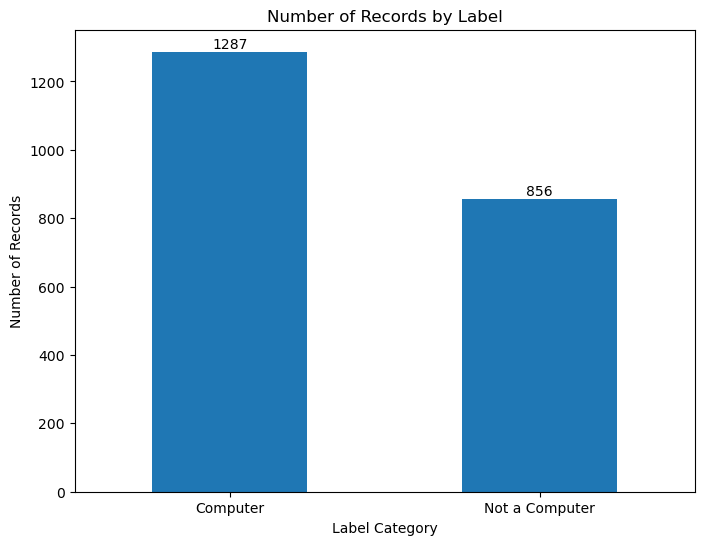

In [6]:
#Comparing the data so as to understand if scaling is required or not

value_counts=df['Label'].value_counts()
percentage=(value_counts/len(df))*100
result=pd.DataFrame({'Count': value_counts, 'Percentage': percentage})
print(result)

result['Count'].plot(kind='bar', figsize=(8, 6))
plt.title('Number of Records by Label')
plt.xlabel('Label Category')
plt.ylabel('Number of Records')

# Adding count values on top of the bars
for i, count in enumerate(result['Count']):
    plt.text(i, count + 10, str(count), ha='center')

plt.xticks(rotation=0)

plt.show()

In [7]:
# Comparing if there are any null values
null_check = df.isnull().any()
percentage_null = (df.isnull().mean()) * 100
result = pd.DataFrame({'Has Null': null_check, 'Percentage Null': percentage_null})

# Display the result
print(result)

             Has Null  Percentage Null
Label           False         0.000000
Product_Url     False         0.000000
Content          True         0.233318
header           True         4.433038


In [8]:
#Extracting the key words from the Product_Url to use it for classification
extracted_url=[]
for i in range(0,len(df)):
    start_index=df['Product_Url'][i].find('/d/')
    end_index=df['Product_Url'][i].rfind('/')
    extracted_url.append(df['Product_Url'][i][start_index+3:end_index])

In [9]:
#Replacing '-' with ' ' to enable tokenization in the later stage
df['Extracted_URL']=extracted_url
df.loc[:, 'Extracted_URL'] = df['Extracted_URL'].str.replace('-', ' ')

In [10]:
df.head()

,Label,Product_Url,Content,header,Extracted_URL
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia),batavia apple mag safe charger
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...,chicago macbook pro 16 screen protector
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN,lisle nib brand new medion wireless
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...,naperville new sealed hp laserjet full
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...,naperville new and sealed link port


In [11]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
df['Flag'] = labelencoder.fit_transform(df['Label'])

In [12]:
df.head()

,Label,Product_Url,Content,header,Extracted_URL,Flag
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia),batavia apple mag safe charger,1
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...,chicago macbook pro 16 screen protector,1
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN,lisle nib brand new medion wireless,1
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...,naperville new sealed hp laserjet full,1
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...,naperville new and sealed link port,1


In [13]:
# Data Cleaning (Tokenization, Lemmatization and Stop word Removal)

from nltk.corpus import stopwords

# Tokenize the collection
token_list = []
for i in df['Extracted_URL']:
    # Handle missing values
    if pd.notnull(i):
        token_list.append(nltk.word_tokenize(i))

# Lemmatize the words
lammetize_list = []
for i in token_list:
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_token = [lemmatizer.lemmatize(token) for token in i]
    lammetize_list.append(lemmatized_token)

# Remove stop words
stop_list = []
for i in lammetize_list:
    stop_words_removed = [token for token in i if not token in stopwords.words('english') if token.isalnum() and token.lower() != 'nan']
    stop_list.append(stop_words_removed)

In [14]:
#Defining a function to again add the token back into a sentence

def convert_to_string(a): 
    
    # initialize an empty string
    first_string = "" 
    
    # traverse in the string  
    for element in a: 
        first_string = first_string+" "+element  
    
    # return string  
    return first_string 

In [15]:
final_list=[]
for i in stop_list:
    sen_list=convert_to_string(i)
    final_list.append(sen_list)

In [16]:
df2=pd.DataFrame(final_list,columns=['Cleaned_URL'])
df2

,Cleaned_URL
0,batavia apple mag safe charger
1,chicago macbook pro 16 screen protector
2,lisle nib brand new medion wireless
3,naperville new sealed hp laserjet full
4,naperville new sealed link port
...,...
2138,oakland compatible hp laserjet
2139,alameda vizio 26 computer monitor
2140,cupertino macbook pro 16 inch loaded m1
2141,fremont 2019 macbook pro 16 inch gb ssd


In [17]:
#Creating the final Dataframe
final=pd.merge(df,df2,left_index=True,right_index=True)
final.head()

,Label,Product_Url,Content,header,Extracted_URL,Flag,Cleaned_URL
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia),batavia apple mag safe charger,1,batavia apple mag safe charger
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...,chicago macbook pro 16 screen protector,1,chicago macbook pro 16 screen protector
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN,lisle nib brand new medion wireless,1,lisle nib brand new medion wireless
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...,naperville new sealed hp laserjet full,1,naperville new sealed hp laserjet full
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...,naperville new and sealed link port,1,naperville new sealed link port


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(final['Cleaned_URL'], final['Flag'], test_size=0.3, random_state=183, shuffle=True)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(min_df=1,ngram_range=(1,2))
v1=vectorizer.fit(X_train)

X_train_transformed=vectorizer.transform(X_train)
X_test_transformed=vectorizer.transform(X_test)

In [20]:
X_train_transformed.shape

(1500, 5824)

In [21]:
X_test_transformed.shape

(643, 5824)

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression model
Logit_model = LogisticRegression()

# Define the parameter grid
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=Logit_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
Logit_model_best = LogisticRegression(**best_params)
Logit_model_best.fit(X_train_transformed, Y_train)

# Evaluation
y_pred_logit_best = Logit_model_best.predict(X_test_transformed)
accuracy_logit_best = accuracy_score(Y_test, y_pred_logit_best)
print("Accuracy of Logit model with best parameters: {:.4f}%".format(accuracy_logit_best * 100))

y_pred_prob_logit_best = Logit_model_best.predict_proba(X_test_transformed)
print(y_pred_prob_logit_best[0])

Best parameters: {'C': 10, 'penalty': 'l2'}
Accuracy of Logit model with best parameters: 86.1586%
[0.10924739 0.89075261]


## Naive Bayes

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
NB_model = MultinomialNB()

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Perform grid search
grid_search = GridSearchCV(NB_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, Y_train)

# Get the best parameter
best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

# Train the model with the best alpha
NB_model_best = MultinomialNB(alpha=best_alpha)
NB_model_best.fit(X_train_transformed, Y_train)

# Evaluation
y_pred_NB_best = NB_model_best.predict(X_test_transformed)
accuracy_best = accuracy_score(Y_test, y_pred_NB_best)
print("Accuracy of Naive Bayes model with best alpha: {:.4f}%".format(accuracy_best * 100))

print(classification_report(y_pred_NB_best,Y_test))
print(confusion_matrix(y_pred_NB_best,Y_test))

Best alpha value: 0.1
Accuracy of Naive Bayes model with best alpha: 86.3142%
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       418
           1       0.77      0.87      0.82       225

    accuracy                           0.86       643
   macro avg       0.85      0.86      0.85       643
weighted avg       0.87      0.86      0.86       643

[[360  58]
 [ 30 195]]


## XGBoost

In [24]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the XGBoost model
xgboost_model = XGBClassifier(random_state=0)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],  # Different learning rates
    'n_estimators': [100, 200, 300],  # Different numbers of trees
    'max_depth': [3, 5, 7],  # Different maximum depths
    'subsample': [0.8, 0.9],  # Different subsample values
}

# Perform grid search
grid_search = GridSearchCV(xgboost_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
xgboost_model_best = XGBClassifier(**best_params, random_state=0)
xgboost_model_best.fit(X_train_transformed, Y_train)

# Evaluation
y_pred_xgboost_best = xgboost_model_best.predict(X_test_transformed)
accuracy_xgboost_best = accuracy_score(Y_test, y_pred_xgboost_best)
print("Accuracy of XGBoost Classifier Model with best parameters: {:.4f}%".format(accuracy_xgboost_best * 100))

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy of XGBoost Classifier Model with best parameters: 83.5148%


## Neural Network

In [25]:
## Neural Network and Deep Learning

DeepLearning_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(150,1400), random_state=1)

# training
DeepLearning_model.fit(X_train_transformed, Y_train)
y_pred_DL= DeepLearning_model.predict(X_test_transformed)

# evaluation
DeepLearning_accuracy = accuracy_score(Y_test, y_pred_DL)
print("Accuracy of Deep Learning model: {:.4f}%".format(DeepLearning_accuracy*100))

y_pred_prob_dl = DeepLearning_model.predict_proba(X_test_transformed)
print(y_pred_prob_dl[0])

Accuracy of Deep Learning model: 84.9145%
[6.57541355e-10 9.99999999e-01]


## Decision Tree

In [26]:
DecisionTree_model = DecisionTreeClassifier(min_samples_leaf=15,random_state=0) ## number of trees and number of layers/depth

#training
DecisionTree_model.fit(X_train_transformed, Y_train)
y_pred_DecisionTree = DecisionTree_model.predict(X_test_transformed)

#evaluation
DecisionTree_accuracy = accuracy_score(Y_test, y_pred_DecisionTree)
print("Decision Tree Model Accuracy: {:.4f}%".format(DecisionTree_accuracy*100))

y_pred_prob_dt_model = DecisionTree_model.predict_proba(X_test_transformed)
print(y_pred_prob_dt_model[0])

Decision Tree Model Accuracy: 80.0933%
[0.26582278 0.73417722]


# Random Forest

In [27]:
RandomForest_model = RandomForestClassifier(n_estimators=300, max_depth=20, bootstrap=True, random_state=0) ## number of trees and number of layers/depth

#training
RandomForest_model.fit(X_train_transformed, Y_train)
y_pred_RandomForest_model = RandomForest_model.predict(X_test_transformed)

#evaluation
RandomForest_model_accuracy = accuracy_score(Y_test, y_pred_RandomForest_model)
print("Random Forest Model Accuracy: {:.4f}%".format(RandomForest_model_accuracy*100))

y_pred_prob_rfmodel = RandomForest_model.predict_proba(X_test_transformed)
print(y_pred_prob_rfmodel[0])

Random Forest Model Accuracy: 80.0933%
[0.46041516 0.53958484]


## LIGHT GBM

In [28]:
import lightgbm as lgb

lgbmodel = lgb.LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=0, verbose=20)
#training
lgbmodel.fit(X_train_transformed, Y_train, eval_metric='logloss')  # Remove the 'verbose' argument here
y_pred_lgb = lgbmodel.predict(X_test_transformed)

#evaluation
acc_lgb = accuracy_score(Y_test, y_pred_lgb)
print("Light GMB Classifier Model Accuracy: {:.4f}%".format(acc_lgb*100))

y_pred_prob_lgb = lgbmodel.predict_proba(X_test_transformed)
print(y_pred_prob_lgb[0])


[LightGBM] [Info] Number of positive: 603, number of negative: 897
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.967692
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.955935
[LightGBM] [Debug] init for col-wise cost 0.001059 seconds, init for row-wise cost 0.000829 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402000 -> initscore=-0.397139
[LightGBM] [Info] Start training from score -0.397139
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [

## CatBoost

In [29]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(random_state=0) ## number of trees and number of layers/depth

#training
cat_model.fit(X_train_transformed, Y_train, verbose=20)
y_pred_cat_model = cat_model.predict(X_test_transformed)

#evaluation
cat_accuracy = accuracy_score(Y_test, y_pred_cat_model)
print("Accuracy of CatBoostClassifier Model: {:.4f}%".format(cat_accuracy *100))

y_pred_prob_cat_model = cat_model.predict_proba(X_test_transformed)
print(y_pred_prob_cat_model[0])

#Accuracy of CatBoostClassifier Model: 83.2037%
# [0.26357764 0.73642236]

Learning rate set to 0.01225
0:	learn: 0.6886707	total: 195ms	remaining: 3m 15s
20:	learn: 0.6142777	total: 740ms	remaining: 34.5s
40:	learn: 0.5638086	total: 1.62s	remaining: 38s
60:	learn: 0.5314165	total: 2.41s	remaining: 37.1s
80:	learn: 0.5067525	total: 2.89s	remaining: 32.8s
100:	learn: 0.4874207	total: 3.42s	remaining: 30.5s
120:	learn: 0.4715074	total: 4.14s	remaining: 30.1s
140:	learn: 0.4577291	total: 5s	remaining: 30.5s
160:	learn: 0.4466579	total: 5.66s	remaining: 29.5s
180:	learn: 0.4352926	total: 6.15s	remaining: 27.8s
200:	learn: 0.4256117	total: 6.72s	remaining: 26.7s
220:	learn: 0.4169068	total: 7.54s	remaining: 26.6s
240:	learn: 0.4096973	total: 8.42s	remaining: 26.5s
260:	learn: 0.4021370	total: 8.91s	remaining: 25.2s
280:	learn: 0.3957664	total: 9.45s	remaining: 24.2s
300:	learn: 0.3897968	total: 10s	remaining: 23.3s
320:	learn: 0.3845850	total: 10.6s	remaining: 22.4s
340:	learn: 0.3790639	total: 11.2s	remaining: 21.6s
360:	learn: 0.3746086	total: 11.7s	remaining: 2

# LSTM

In [30]:
from numpy import array
from sklearn.preprocessing import LabelEncoder
docs_x=final['Cleaned_URL']
docs_c=final['Flag']

In [31]:
# Count words and create a vocabulary
from collections import Counter
words = [j for i in docs_x for j in i]
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w: i+1 for i, (w, c) in enumerate(sorted_words)}  # Note: 0 is reserved for null

# One-hot encode the text
text_int = []
for i in docs_x:
    r = [vocab_to_int[w] for w in i]
    text_int.append(r)

# Encode labels (assuming 'subj' is positive class, and others are negative)
encoded_labels = [1 if label == 'subj' else 0 for label in docs_c]

In [32]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(text_int, encoded_labels, test_size=0.3, random_state=13)
y_train = np.array(Y_train_lstm)
y_test = np.array(Y_test_lstm)


maxlen = 200  # Example: setting a fixed length of 100
x_train_padded = pad_sequences(X_train_lstm, maxlen=maxlen)
x_test_padded = pad_sequences(X_test_lstm, maxlen=maxlen)

x_train = np.array(x_train_padded)
x_test = np.array(x_test_padded)

In [33]:
# build model
import keras
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding, Flatten
from keras.layers import LSTM
from keras.layers import Dense, Dropout
max_features = total_words
maxlen = 200
batch_size = 100

# model architecture
model = Sequential()
model.add(Embedding(max_features, 20, input_length=maxlen))
model.add(LSTM(40, dropout=0.20, recurrent_dropout=0.20))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=5, validation_data=(x_test, y_test))



Epoch 1/5


15/15 [==============================] - 5s 164ms/step - loss: 0.6261 - accuracy: 0.9267 - val_loss: 0.4789 - val_accuracy: 1.0000
Epoch 2/5
15/15 [==============================] - 2s 151ms/step - loss: 0.1557 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 3/5
15/15 [==============================] - 2s 151ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/5
15/15 [==============================] - 2s 151ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 9.9072e-04 - val_accuracy: 1.0000
Epoch 5/5
15/15 [==============================] - 2s 148ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 7.2474e-04 - val_accuracy: 1.0000
